In [11]:
import os
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from config import Config
from feature_engineering.data_engineering import data_engineer_benchmark, span_data_2d, span_data_3d
import logging
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import yaml

Python 文件的导入部分，主要用于引入项目中需要的模块和库，为后续的功能实现提供支持。以下是对每个导入的详细解释：

1. **`import os`**:  
   `os` 模块提供了与操作系统交互的功能，例如文件路径操作、环境变量访问等。它通常用于处理文件和目录路径，确保代码能够在不同操作系统上运行。

2. **`from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter`**:  
   `argparse` 是 Python 标准库中的一个模块，用于解析命令行参数。`ArgumentParser` 是核心类，用于定义和解析命令行参数，而 `ArgumentDefaultsHelpFormatter` 可以自动生成帮助信息，并显示参数的默认值。这两个工具通常用于构建灵活的命令行接口。

3. **`from config import Config`**:  
   这行代码从项目中的 [`config`](command:_github.copilot.openRelativePath?%5B%22config%22%5D "config") 模块导入了 [`Config`](command:_github.copilot.openRelativePath?%5B%22Config%22%5D "Config") 类或对象。[`Config`](command:_github.copilot.openRelativePath?%5B%22Config%22%5D "Config") 通常用于管理项目的配置参数，例如路径、超参数或其他全局设置。这种设计可以让代码更易于维护和扩展。

4. **`from feature_engineering.data_engineering import data_engineer_benchmark, span_data_2d, span_data_3d`**:  
   这行代码从项目的 `feature_engineering.data_engineering` 模块中导入了三个函数或类：`data_engineer_benchmark`、`span_data_2d` 和 `span_data_3d`。这些工具可能与特征工程相关，用于处理数据或生成特定的特征，例如二维或三维数据的跨度计算。

5. **`import logging`**:  
   `logging` 模块是 Python 标准库的一部分，用于记录日志信息。它可以帮助开发者跟踪代码的运行状态、调试问题或记录重要事件。通过设置不同的日志级别（如 DEBUG、INFO、WARNING），可以灵活地控制日志输出。

6. **`import numpy as np`**:  
   `numpy` 是一个强大的科学计算库，主要用于处理多维数组和执行数值计算。这里将 `numpy` 重命名为 `np`，这是一个常见的约定，方便代码书写和阅读。

7. **`import pandas as pd`**:  
   `pandas` 是一个流行的数据分析库，提供了强大的数据结构（如 DataFrame）和工具，用于处理和分析结构化数据。这里将 `pandas` 重命名为 `pd`，也是一种常见的约定。

8. **`from sklearn.model_selection import train_test_split`**:  
   这行代码从 `scikit-learn` 库中导入了 `train_test_split` 函数，用于将数据集分割为训练集和测试集。这是机器学习项目中常用的工具，确保模型能够在未见过的数据上进行评估。

9. **`import yaml`**:  
   `yaml` 是一个轻量级的数据序列化格式，常用于配置文件。`yaml` 模块可以解析 YAML 文件，将其转换为 Python 数据结构（如字典），或者将 Python 数据结构写入 YAML 文件。

此处导入了多个标准库和第三方库，以及项目中的自定义模块，涵盖了文件操作、命令行参数解析、特征工程、数据处理、日志记录等功能。这些导入为后续代码的实现提供了必要的工具和支持，体现了模块化和可扩展的设计思想。

In [12]:
logger = logging.getLogger(__name__)

创建了一个与当前模块关联的日志记录器对象，为后续的日志记录提供了基础。这种设计不仅提高了代码的可维护性，还增强了项目的调试能力。

In [13]:
import warnings

# 忽略所有的警告
warnings.filterwarnings("ignore")

为了使用GPU进行训练，我配置的pytorch版本、cuda版本、dgl版本更加高，以至于与模型部分函数命名，关联有冲突，我在相应修改模型使用函数后，可以正常训练，但训练中仍有版本信息提示，故在此处忽略提示信息，以更加清晰地展现实验效果

In [14]:
def parse_args(method):
    # 根据选择的方法设置配置文件的路径
    yaml_file = {
        'gtan': "config/gtan_cfg.yaml",
        'rgtan': "config/rgtan_cfg.yaml",
        'rgtan-n': "config/rgtan_n_cfg.yaml",
        'rgtan-r': "config/rgtan_r_cfg.yaml",
        'rgtan-a': "config/rgtan_a_cfg.yaml",
    }.get(method, None)

    if not yaml_file:
        raise NotImplementedError(f"Unsupported method: {method}")

    # 读取配置文件
    with open(yaml_file) as file:
        args = yaml.safe_load(file)
    args['method'] = method
    return args

这段代码定义了一个名为 `parse_args` 的函数，用于根据输入的 `method` 参数选择对应的配置文件，并将配置文件中的内容加载为 Python 数据结构。

1. **函数的目的**:
   `parse_args` 函数的主要作用是根据用户提供的 `method` 参数，选择一个预定义的 YAML 配置文件路径，并加载该文件的内容。加载后的配置数据会以字典形式返回，同时添加一个 `method` 键，记录用户选择的 `method`。

2. **配置文件路径的选择**:
   - 函数通过一个字典将不同的 `method` 值映射到对应的配置文件路径。例如：
     - 如果 `method` 是 `'gtan'`，则选择 `"config/gtan_cfg.yaml"`。
     - 如果 `method` 是 `'rgtan'`，则选择 `"config/rgtan_cfg.yaml"`。
   - 使用 `.get(method, None)` 方法从字典中获取对应的路径。如果 `method` 不在字典中，则返回 `None`。

3. **错误处理**:
   - 如果 `method` 不在预定义的字典中（即 `yaml_file` 为 `None`），函数会抛出一个 `NotImplementedError` 异常，并提示用户提供的 `method` 不受支持。这种设计可以防止程序继续运行时出现不可预测的错误。

4. **读取 YAML 配置文件**:
   - 使用 `open(yaml_file)` 打开选定的配置文件，并通过 `yaml.safe_load(file)` 将 YAML 文件的内容加载为 Python 数据结构（通常是字典）。
   - `yaml.safe_load` 是 `PyYAML` 库中的方法，用于安全地加载 YAML 文件，避免潜在的安全问题。

5. **添加 `method` 信息**:
   - 加载的配置数据会被添加一个新的键值对：`args['method'] = method`。这样可以在后续使用配置数据时，明确知道用户选择的 `method`。

6. **返回值**:
   - 函数最终返回加载后的配置数据（字典形式），其中包含 YAML 文件的内容以及用户选择的 `method`。

### 示例用法
假设用户调用函数时传入 `'gtan'`：
```python
args = parse_args('gtan')
```
函数会加载 `"config/gtan_cfg.yaml"` 文件，并返回类似以下的字典：
```python
{
    'method': 'gtan',
    'key1': 'value1',
    'key2': 'value2',
    ...
}
```

### 总结
`parse_args` 函数通过灵活的字典映射和错误处理机制，确保能够根据用户输入加载正确的配置文件，同时提供了清晰的扩展性。如果需要支持新的 `method`，只需在字典中添加新的键值对即可。这种设计简洁且易于维护，非常适合配置管理场景。

In [15]:
def base_load_data(args):
    # 供普通的非图结构的模型使用的S-SSFD
    data_path = "data/S-FFSD.csv"
    feat_df = pd.read_csv(data_path)
    train_size = 1 - args['test_size']

    # 检查是否已有预处理的数据
    if os.path.exists("data/tel_2d.npy"):
        return
    
    # 数据预处理
    features, labels = span_data_2d(feat_df)  # 请确保定义了该函数
    trf, tef, trl, tel = train_test_split(
        features, labels, train_size=train_size, stratify=labels, shuffle=True
    )
    
    # 保存数据
    np.save(args['trainfeature'], trf)
    np.save(args['testfeature'], tef)
    np.save(args['trainlabel'], trl)
    np.save(args['testlabel'], tel)

In [16]:
def main(args):
    if args['method'] == 'rgtan':
        from methods.rgtan.rgtan_main import rgtan_main, loda_rgtan_data
        feat_data, labels, train_idx, test_idx, g, cat_features, neigh_features = loda_rgtan_data(args['dataset'], args['test_size'])
        rgtan_main(feat_data, g, train_idx, test_idx, labels, args, cat_features, neigh_features, nei_att_head=args['nei_att_heads'][args['dataset']])

    elif args['method'] == 'gtan':
        from methods.gtan.gtan_main import gtan_main, load_gtan_data
        feat_data, labels, train_idx, test_idx, g, cat_features = load_gtan_data(args['dataset'], args['test_size'])
        gtan_main(feat_data, g, train_idx, test_idx, labels, args, cat_features)

    elif args['method'] == 'rgtan-n':
        from methods.rgtan_n.rgtan_n_main import rgtan_n_main, loda_rgtan_data
        feat_data, labels, train_idx, test_idx, g, cat_features, neigh_features = loda_rgtan_data(args['dataset'], args['test_size'])
        rgtan_n_main(feat_data, g, train_idx, test_idx, labels, args, cat_features, neigh_features, nei_att_head=args['nei_att_heads'][args['dataset']])

    elif args['method'] == 'rgtan-r':
        from methods.rgtan_r.rgtan_r_main import rgtan_r_main, loda_rgtan_data
        feat_data, labels, train_idx, test_idx, g, cat_features, neigh_features = loda_rgtan_data(args['dataset'], args['test_size'])
        rgtan_r_main(feat_data, g, train_idx, test_idx, labels, args, cat_features, neigh_features, nei_att_head=args['nei_att_heads'][args['dataset']])

    elif args['method'] == 'rgtan-a':
        from methods.rgtan_a.rgtan_a_main import rgtan_a_main, loda_rgtan_data
        feat_data, labels, train_idx, test_idx, g, cat_features, neigh_features = loda_rgtan_data(args['dataset'], args['test_size'])
        rgtan_a_main(feat_data, g, train_idx, test_idx, labels, args, cat_features, neigh_features, nei_att_head=args['nei_att_heads'][args['dataset']])
    else:
        raise NotImplementedError("Unsupported method.")

以下是在amazon数据集上进行的原始模型和消融实验训练评估可视化
相关参数配置如下：
batch_size: 64

hid_dim: 256

lr: 0.0003

wd: !!float 1e-4

n_layers: 2

dropout: [0.2, 0.1]

device: "cuda:0"

early_stopping: 10

n_fold: 5

seed: 2023

max_epochs: 100

gated: True

dataset: amazon

test_size: 0.4

nei_att_heads:

    yelp: 4

    amazon: 5
    
    S-FFSD: 9

exp1---rgtan---amazon

In [25]:
method = 'rgtan'  # 可以根据需要更改
args = parse_args(method)
base_load_data(args)
main(args)

neighborhood feature loaded for nn input.
Training fold 1
In epoch:000|batch:0000, train_loss:0.652636, train_ap:0.2656, train_acc:0.6406, train_auc:0.6244
In epoch:000|batch:0010, train_loss:0.624114, train_ap:0.2615, train_acc:0.7188, train_auc:0.6707
In epoch:000|batch:0020, train_loss:0.591617, train_ap:0.2847, train_acc:0.8281, train_auc:0.8102
In epoch:000|batch:0030, train_loss:0.565658, train_ap:0.4658, train_acc:0.8125, train_auc:0.7939
In epoch:000|batch:0040, train_loss:0.538152, train_ap:0.6651, train_acc:0.9062, train_auc:0.8508
In epoch:000|batch:0050, train_loss:0.516140, train_ap:0.6522, train_acc:0.9062, train_auc:0.9152
In epoch:000|batch:0060, train_loss:0.494926, train_ap:0.8510, train_acc:0.9531, train_auc:0.9511
In epoch:000|batch:0000, val_loss:0.004611, val_ap:0.4096, val_acc:0.9219, val_auc:0.6644
In epoch:000|batch:0010, val_loss:0.004262, val_ap:0.9034, val_acc:0.9531, val_auc:0.9774
In epoch:001|batch:0000, train_loss:0.388373, train_ap:0.5512, train_acc:0.9

exp2---rgtan-a---amazon

In [21]:
method = 'rgtan-a'  # 可以根据需要更改
args = parse_args(method)
base_load_data(args)
main(args)

neighborhood feature loaded for nn input.
Training fold 1
In epoch:000|batch:0000, train_loss:0.652705, train_ap:0.0796, train_acc:0.6562, train_auc:0.4475
In epoch:000|batch:0010, train_loss:0.615805, train_ap:0.2652, train_acc:0.6094, train_auc:0.6963
In epoch:000|batch:0020, train_loss:0.596654, train_ap:0.1294, train_acc:0.6094, train_auc:0.4424
In epoch:000|batch:0030, train_loss:0.580442, train_ap:0.0947, train_acc:0.8281, train_auc:0.5390
In epoch:000|batch:0040, train_loss:0.565919, train_ap:0.3143, train_acc:0.8594, train_auc:0.7153
In epoch:000|batch:0050, train_loss:0.552643, train_ap:0.1683, train_acc:0.8750, train_auc:0.7241
In epoch:000|batch:0060, train_loss:0.536707, train_ap:0.0881, train_acc:0.9688, train_auc:0.6452
In epoch:000|batch:0000, val_loss:0.011252, val_ap:0.0647, val_acc:0.4375, val_auc:0.1839
In epoch:000|batch:0010, val_loss:0.011165, val_ap:0.0534, val_acc:0.5000, val_auc:0.2958
In epoch:001|batch:0000, train_loss:0.425702, train_ap:0.1254, train_acc:0.9

exp3---rgtan-n---amazon

In [26]:
method = 'rgtan-n'  # 可以根据需要更改
args = parse_args(method)
base_load_data(args)
main(args)

neighborhood feature loaded for nn input.
Training fold 1
In epoch:000|batch:0000, train_loss:0.725332, train_ap:0.1800, train_acc:0.5156, train_auc:0.5778
In epoch:000|batch:0010, train_loss:0.634543, train_ap:0.5878, train_acc:0.7031, train_auc:0.8415
In epoch:000|batch:0020, train_loss:0.555055, train_ap:0.8041, train_acc:0.9062, train_auc:0.9172
In epoch:000|batch:0030, train_loss:0.511863, train_ap:0.7345, train_acc:0.9062, train_auc:0.8696
In epoch:000|batch:0040, train_loss:0.481702, train_ap:0.0455, train_acc:0.7656, train_auc:0.4839
In epoch:000|batch:0050, train_loss:0.465998, train_ap:0.8095, train_acc:0.9531, train_auc:0.9781
In epoch:000|batch:0060, train_loss:0.442856, train_ap:0.6994, train_acc:0.9531, train_auc:0.8793
In epoch:000|batch:0000, val_loss:0.003510, val_ap:0.6678, val_acc:0.9531, val_auc:0.8420
In epoch:000|batch:0010, val_loss:0.003621, val_ap:0.6412, val_acc:0.9531, val_auc:0.8958
In epoch:001|batch:0000, train_loss:0.261982, train_ap:0.7140, train_acc:0.9

exp4---rgtan-r---amazon

In [27]:
method = 'rgtan-r'  # 可以根据需要更改
args = parse_args(method)
base_load_data(args)
main(args)

neighborhood feature loaded for nn input.
Training fold 1
In epoch:000|batch:0000, train_loss:0.855861, train_ap:0.1548, train_acc:0.4219, train_auc:0.7017
In epoch:000|batch:0010, train_loss:0.730253, train_ap:0.7058, train_acc:0.5156, train_auc:0.8000
In epoch:000|batch:0020, train_loss:0.668392, train_ap:1.0000, train_acc:0.7500, train_auc:1.0000
In epoch:000|batch:0030, train_loss:0.610026, train_ap:0.8269, train_acc:0.6719, train_auc:0.9625
In epoch:000|batch:0040, train_loss:0.574729, train_ap:1.0000, train_acc:0.9531, train_auc:1.0000
In epoch:000|batch:0050, train_loss:0.529835, train_ap:0.7890, train_acc:0.9219, train_auc:0.8170
In epoch:000|batch:0060, train_loss:0.497462, train_ap:1.0000, train_acc:0.9844, train_auc:1.0000
In epoch:000|batch:0000, val_loss:0.003044, val_ap:0.7644, val_acc:0.9688, val_auc:0.9583
In epoch:000|batch:0010, val_loss:0.003508, val_ap:0.4809, val_acc:0.9219, val_auc:0.7730
In epoch:001|batch:0000, train_loss:0.426661, train_ap:0.6070, train_acc:0.9

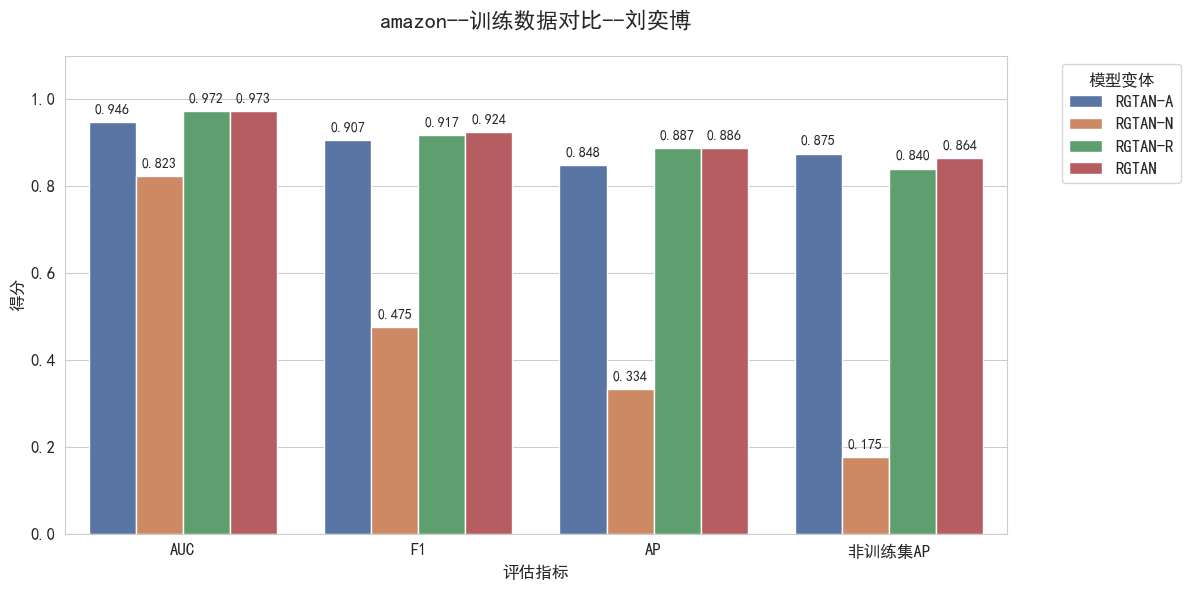

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.font_manager as fm

# 1. 中文字体配置（确保路径正确）
font_path = 'C:/Windows/Fonts/simhei.ttf'  # Windows系统黑体路径
myfont = fm.FontProperties(fname=font_path, size=12)
rcParams['font.sans-serif'] = ['SimHei']  # 全局设置
rcParams['axes.unicode_minus'] = False    # 解决负号显示

# 2. 数据准备（移除无效的0.000数据点）
data = {
    '模型': ['RGTAN-A', 'RGTAN-N', 'RGTAN-R', 'RGTAN'],
    'AUC': [0.9464, 0.8229, 0.9717, 0.9733],
    'F1': [0.9069, 0.4750, 0.9171, 0.9245],
    'AP': [0.8475, 0.3335, 0.8874, 0.8865],
    '非训练集AP': [0.8749, 0.1753, 0.8404, 0.8644]
}
df = pd.DataFrame(data)

# 3. 数据重塑
df_melted = df.melt(id_vars=['模型'], 
                    var_name='指标', 
                    value_name='得分')

# 4. 可视化
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='指标', y='得分', hue='模型', data=df_melted,
                 palette=['#4C72B0', '#DD8452', '#55A868', '#C44E52'])

# 5. 图表美化
plt.title('amazon--训练数据对比--刘奕博', fontproperties=myfont, fontsize=16, pad=20)
plt.xlabel('评估指标', fontproperties=myfont)
plt.ylabel('得分', fontproperties=myfont)
plt.ylim(0, 1.1)

# 修正1：过滤无效的0.000标注
for p in ax.patches:
    height = p.get_height()
    if height > 0.01:  # 忽略接近0的值
        ax.text(p.get_x() + p.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', fontsize=10, fontproperties=myfont)

# 修正2：强制图例使用中文
legend = ax.legend(title='模型变体', 
                  bbox_to_anchor=(1.05, 1), 
                  loc='upper left',
                  prop=myfont)  # 关键：prop直接传递myfont
legend.get_title().set_fontproperties(myfont)  # 单独设置标题字体

plt.xticks(fontproperties=myfont)
plt.yticks(fontproperties=myfont)
plt.tight_layout()
plt.savefig('amazon_训练数据对比.png', dpi=300, bbox_inches='tight', facecolor='white')  
plt.show()